## Avocado Downstream Task Demo

In this notebook we will give a demonstration of how one would compare different feature sets to identify the best performing one. This example will be in the context of predicting gene expression for IMR90 (E017) and for predicting FIREs in GM12878 (E116). The data has been pre-extracted, and is the same data that is used for the manuscript. In the case of FIRE prediction, we use a subset due to the size of the data.

This evaluation setup involves extracting feature sets from relevant regions in the genome and then performing cross-validated gradient boosting, reporting the mean average precision across the 20 folds.

In [1]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')
import xgboost
import os

from sklearn.metrics import average_precision_score

%load_ext watermark
%watermark -n -m -p numpy,pandas,sklearn,xgboost,matplotlib,seaborn

Populating the interactive namespace from numpy and matplotlib
Fri Oct 19 2018 

numpy 1.15.2
pandas 0.23.4
sklearn 0.20.0
xgboost 0.80
matplotlib 3.0.0
seaborn 0.9.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.15.0-36-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


First let's write out script for taking in a data set and performing 5 fold cross validation on it.

In [2]:
def make_predictions(X, y):
    """Perform 5 fold cross-validation on a data set.
    
    This function will evaluate how well some feature set can predict
    gene expression using five fold cross validation and a gradient
    boosting machine. The data is first shuffled and then split into
    five folds. Three of the folds are used for training the model,
    one of the folds is used as a validation set to determine when to
    stop training the model, and one of the folds is the held out
    test set. The setting of the random seed ensures that the folds
    are the same for each feature set and that everything else is
    identical between runs.
    
    Parameters
    ----------
    X : numpy.ndarray, shape (n, d)
        This is the input data. Each row is a sample and each column
        is a dimension. The different feature sets will have the same
        number of rows but may have a different number of features.
    
    y : numpy.ndarray, shape (n,)
        This is the label vector. Regardless of how many features there
        are in the feature set, there is only one label per sample.
        
    Returns
    -------
    average_precisions : numpy.ndarray, shape (5,)
        This is the average precision over each of the five folds.
    """
    
    numpy.random.seed(0)

    idx = numpy.arange(X.shape[0])
    numpy.random.shuffle(idx)
    X, y = X[idx], y[idx]

        average_precisions = numpy.zeros(20)
    for i in range(20):
        X_test = X[i::20]
        X_valid = X[(i+1)%20::20]
        X_train = numpy.concatenate([X[j::20] for j in range(20) if j != i and j != (i+1)%20])

        y_test = y[i::20]
        y_valid = y[(i+1)%20::20]
        y_train = numpy.concatenate([y[j::20] for j in range(20) if j != i and j != (i+1)%20])

        model = xgboost.XGBClassifier(n_estimators=5000, nthread=min(X_train.shape[1], 4), max_depth=6)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='map', early_stopping_rounds=20, verbose=False)

        y_hat = model.predict_proba(X_test)
        average_precisions[i] = average_precision_score(y_test, y_hat[:,1])

    return average_precisions


def celltype_baseline(y):
    """This returns the baseline average precision"""
    
    y_hat = numpy.zeros_like(y) + y.mean()
    return average_precision_score(y, y_hat)

### Gene Expression in IMR90

Now let's load up the pre-extracted feature sets for gene expression. These feature sets correspond to the ChIP-seq experiments that have been performed in IMR90, which is all 24, the imputed versions of those 24 experiments using each of the three imputation approaches, using the Avocado latent factors, or using the full set of 1,014 epigenomic measurements. If you'd like to restrict the number of genes, due to the computational cost or otherwise, set `n` to be a lower number.

In [3]:
n = 16724 # Make this number smaller to consider only a subset of data.

X1 = numpy.load('data/RNAseq.E017.Roadmap.npy')[:n]
X2 = numpy.load('data/RNAseq.E017.ChromImpute.npy')[:n]
X3 = numpy.load('data/RNAseq.E017.PREDICTD.npy')[:n]
X4 = numpy.load('data/RNAseq.E017.AvocadoImp.npy')[:n]
X5 = numpy.load('data/RNAseq.E017.AvocadoFac.npy')[:n]
X6 = numpy.load('data/RNAseq.E017.AllRoadmap.npy')[:n]
y = numpy.load('data/RNAseq.E017.y.npy')[:n]
y = (y >= 0.5).astype(int)

Now let's make predictions using these feature sets. Since we already wrote a function to take in a feature set and some labels and make the predictions, all we have to do is pass in each feature set with the same set of labels and get back the performance.

In [4]:
maps = numpy.zeros((7, 20))
maps[0] = celltype_baseline(y)
maps[1] = make_predictions(X1, y)
maps[2] = make_predictions(X2, y)
maps[3] = make_predictions(X3, y)
maps[4] = make_predictions(X4, y)
maps[5] = make_predictions(X5, y)
maps[6] = make_predictions(X6, y)

Now let's plot the performance of each of the feature sets with error bars corresponding to the standard error of the mean.

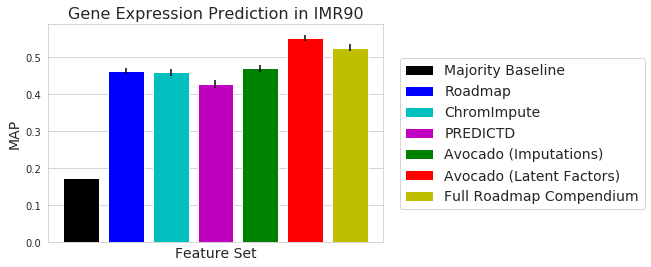

In [5]:
x = numpy.arange(7)

plt.title("Gene Expression Prediction in IMR90", fontsize=16)
plt.bar([0], maps[0].mean(), color='k', label="Majority Baseline")
plt.bar([1], maps[1].mean(), color='b', label="Roadmap")
plt.bar([2], maps[2].mean(), color='c', label="ChromImpute")
plt.bar([3], maps[3].mean(), color='m', label="PREDICTD")
plt.bar([4], maps[4].mean(), color='g', label="Avocado (Imputations)")
plt.bar([5], maps[5].mean(), color='r', label="Avocado (Latent Factors)")
plt.bar([6], maps[6].mean(), color='y', label="Full Roadmap Compendium")
plt.errorbar(x, maps.mean(axis=1), yerr=maps.std(axis=1) / numpy.sqrt(20), c='k', fmt="none")
plt.ylabel("MAP", fontsize=14)
plt.xlabel("Feature Set", fontsize=14)
plt.legend(fontsize=14, loc=(1.05, 0.15))
plt.xticks([], [])
plt.show()

### FIRE Prediction in GM12878

Now let's turn to the task of predicting FIREs in GM12878. Across all cell types, the full Roadmap compendium outperformed using the Avocado latent factors, and we'll see that trend again here. In the manuscript, there are over 70,000 samples per cell type. Since that takes up a lot of space, we'll look only at a subset of 3,000 samples here.

A benefit of our modular setup is that we can re-use the `make_predictions` and `celltype_baseline` functions, just passing in feature sets and label sets that correspond to the FIRE prediction task instead of the gene expression prediction task.

In [6]:
n = 3000

X1 = numpy.load('data/FIREs.E116.Roadmap.npy')[:n]
X2 = numpy.load('data/FIREs.E116.ChromImpute.npy')[:n]
X3 = numpy.load('data/FIREs.E116.PREDICTD.npy')[:n]
X4 = numpy.load('data/FIREs.E116.AvocadoImp.npy')[:n]
X5 = numpy.load('data/FIREs.E116.AvocadoFac.npy')[:n]
X6 = numpy.load('data/FIREs.E116.AllRoadmap.npy')[:n]
y  = numpy.load('data/FIREs.E116.y.npy')[:n]

In [7]:
maps = numpy.zeros((7, 20))
maps[0] = celltype_baseline(y)
maps[1] = make_predictions(X1, y)
maps[2] = make_predictions(X2, y)
maps[3] = make_predictions(X3, y)
maps[4] = make_predictions(X4, y)
maps[5] = make_predictions(X5, y)
maps[6] = make_predictions(X6, y)

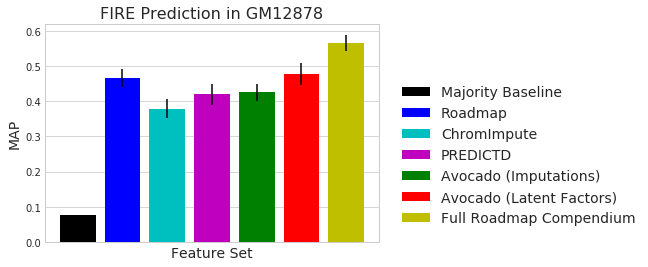

In [8]:
plt.title("FIRE Prediction in GM12878", fontsize=16)
plt.bar([0], maps[0].mean(), color='k', label="Majority Baseline")
plt.bar([1], maps[1].mean(), color='b', label="Roadmap")
plt.bar([2], maps[2].mean(), color='c', label="ChromImpute")
plt.bar([3], maps[3].mean(), color='m', label="PREDICTD")
plt.bar([4], maps[4].mean(), color='g', label="Avocado (Imputations)")
plt.bar([5], maps[5].mean(), color='r', label="Avocado (Latent Factors)")
plt.bar([6], maps[6].mean(), color='y', label="Full Roadmap Compendium")
plt.errorbar(x, maps.mean(axis=1), yerr=maps.std(axis=1) / numpy.sqrt(20), c='k', fmt="none")
plt.ylabel("MAP", fontsize=14)
plt.xlabel("Feature Set", fontsize=14)
plt.legend(fontsize=14, loc=(1.05, 0.05))
plt.xticks([], [])
plt.show()